# 0. Data preparation

In [1]:
import pandas as pd

ahp_weight = pd.read_excel("ahp_240122.xlsx", sheet_name = "AHP_weights", nrows= 15, usecols=range(6)) # Extraction of upper left table. 
survey_points = pd.read_excel("ahp_240122.xlsx", sheet_name ="Calc", usecols=range(19))
group_1 = survey_points[survey_points["Category"]=="Group_1"].copy()
group_2 = survey_points[survey_points["Category"]=="Group_2"].copy()

In [2]:
# Calc of getting lost score for group_1. 
ahp_group_dict = ahp_weight.set_index('Weights')['Group result'].to_dict()
group_1['getting_lost_score'] = group_1.apply(lambda row: sum(row[key] * ahp_group_dict[key] for key in ahp_group_dict if key in row), axis=1)
avg_group1_score = group_1['getting_lost_score'].mean()
print(f"The average getting lost score of survey points in group 1 is:{avg_group1_score: .2f}.")

The average getting lost score of survey points in group 1 is: 0.60.


# 1. VIF (Variance Inflation Factor) analysis and Correlation matrix

 - In this section, we investigate two things of the data: Multicolinearity and correlation of the getting lost factors (for group_1). 
 - Multicolinearity via VIF: Based on the result, there is no strong mulcolinearity exibited by the factors. 
    - More specifically, all the four constantly valued factors don't show any multicolinearity with others, which is logical. 
    - Three factors (Angular distance, Pedestrian flow and Number of landmarks) have relatively stronger VIF. As their VIF are all below 5, which is a conventional threshold criteria of obvious multicolinearity, we will include all of them for future analysis. 
 - Correlation: 
    - The correlation of constantly-valued factors is undefined. 
    - The upper left triangle implies a relatively stroger correlations among the factors of Number of exits/Angular distance/Pedestrian flow/Transportation flow, which complies with our expectation and intuition. 
    - Interestingly, the strongest negative correlation is observed between Number of AOI and Pedestrian flow. Why is it so? 
    - Except the factors mentioned above, the other factors are not correlated as much. 

In [3]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

df = group_1.iloc[:,5:19]
X = sm.add_constant(df)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

    VIF Factor                                       features
0     2.747027                           ID_1_Number of Exits
1     4.001139            ID_2_Angular distance between exits
2     4.929070                           ID_3_Pedestrian Flow
3     2.077315                       ID_4_Transportation Flow
4     1.619731                                ID_5_Visibility
5     0.000000                 ID_6_Number of decision points
6     4.342058  ID_7_Number of Landmarks near decision points
7     0.000000                   ID_8_Self-orientation skills
8     1.229926  ID_9_Personal context (tiredness_impairment_e
9     0.000000                 ID_10_Number of turning points
10    0.000000            ID_11_City/Smaller scale complexity
11    1.782824                   ID_12_Access to reliable map
12    1.792137                              ID_13_Familiarity
13    1.789954                          ID_14_Name_similarity


C:\Users\2715439W\AppData\Local\miniconda3\envs\tf2\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


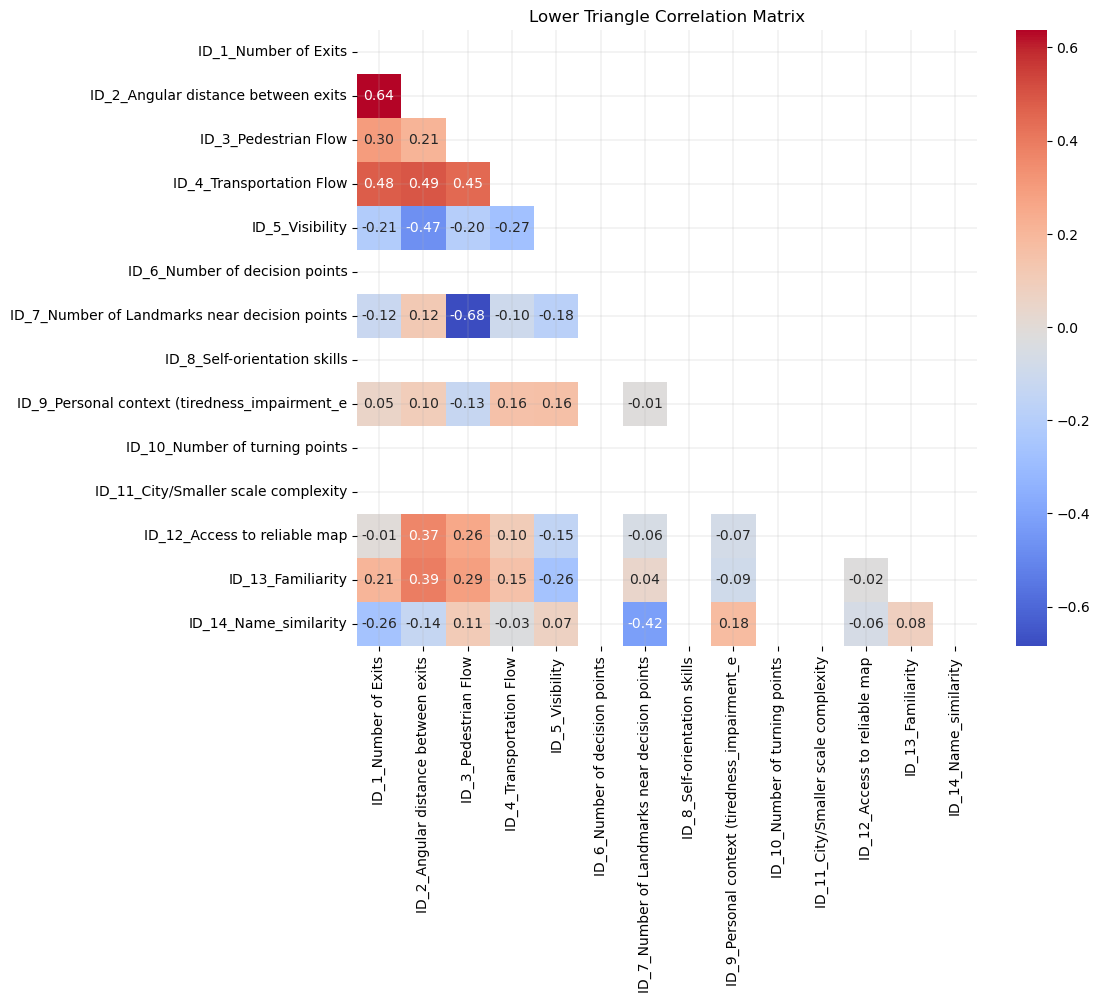

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

corr_matrix = group_1.iloc[:,5:19].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, mask=mask, fmt=".2f", cmap='coolwarm')
plt.title("Lower Triangle Correlation Matrix")
plt.grid(linewidth=0.2)
plt.show()


# 2. Implement of OLS regression for coefficient exploration. 

Due to four constantly-valued factors, the simple OLS regression fits the model by setting non-zero values to them and all zeros for all the other getting lost factors. 

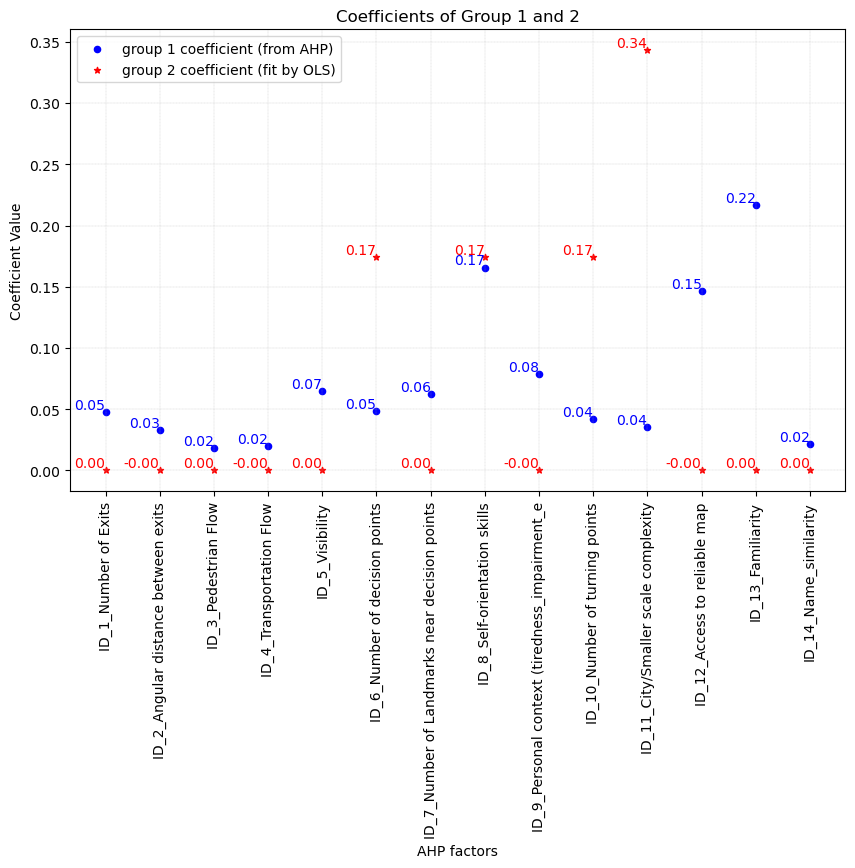

In [5]:
# OLS applied on all of the 14 factors. 
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt

X = group_2.iloc[:, 5:]  # feature: X starts from fifth column of the Calc table. 
y = [avg_group1_score] * len(group_2)  # fit target: y =0.6 across all points in group_2

X = sm.add_constant(X) # Add constant term
model = sm.OLS(y, X).fit()

OLS_coeffs = model.params

plt.figure(figsize=(10, 6))
plt.scatter(ahp_group_dict.keys(), ahp_group_dict.values(), label='group 1 coefficient (from AHP)', marker='o', s=20, color = 'b')
for key, value in ahp_group_dict.items():
    plt.text(key, value, f"{value:.2f}", ha='right', va='bottom', color='b')
plt.scatter(OLS_coeffs.index, OLS_coeffs.values, label='group 2 coefficient (fit by OLS)',marker = '*', s=20, color='r')
for idx, value in enumerate(OLS_coeffs.values):
    plt.text(OLS_coeffs.index[idx], value, f"{value:.2f}", ha='right', va='bottom', color='r')
    
plt.xlabel('AHP factors')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=90)
plt.title('Coefficients of Group 1 and 2')
plt.legend(loc="upper left")
plt.grid(linestyle='--', linewidth=0.2)
plt.show()

# 3. Implement Ridge regression (OLS with L2) with the following bounding conditions:

 - We applied a ridge regression which incorporates an OLS model and a penalty term to alleviate overfitting and make overweighted coefficients less significant. 
 - Two constraint conditions were added: 1. All of the 14 identified weights must be added up to one. 2. Only non-negative coefficients are allowed. 
 - At the end of this section, we calculated the standard deviation betwen the identified coeffs of group 2 and those from group 1, resulting 6%. 

In [6]:
import numpy as np
from scipy.optimize import minimize

# loss function: mean square error MSE.
def loss_function(coeffs, X, y, lambda_):
    y_pred = X.dot(coeffs)
    mse = np.mean((y - y_pred) ** 2)
    l2_penalty = lambda_ * np.sum(np.square(list(coeffs)))
    return mse + l2_penalty
lambda_ = 0.1
# constraint 1: all coeffs are added up to 1. 
cons = ({'type': 'eq', 'fun': lambda coeffs:  np.sum(coeffs) - 1})
# constraint 2: bound of each coeff starts from zero (i.e., no negative coeff.)
bounds = [(0, None) for _ in range(X.shape[1])]

# initiate coeffs.
initial_coeffs = np.ones(X.shape[1])   # 均匀分配初始值

# optimization via minimizing loss function with constraints
result = minimize(loss_function, initial_coeffs, args=(X, y, lambda_), constraints=cons, bounds=bounds)
# result = minimize(loss_function, initial_coeffs, args=(X_to_fit, y, X_fixed, fixed_coefficients, lambda_), constraints=cons, bounds=bounds)

fitted_coeffs = result.x
fitted_coeffs_dict = dict(zip(X.columns, fitted_coeffs))

# print the variance of derived coeffs and ahp weights
differences = []
for key in fitted_coeffs_dict:
    if key in ahp_group_dict:
        diff = fitted_coeffs_dict[key] - ahp_group_dict[key]
        differences.append(diff)
std = np.std(differences)
print(f"standard deviation of (constrained optim - ahp weights): {std:.2f}")

standard deviation of (constrained optim - ahp weights): 0.06


# 4. Fix and fit method

 - Only explore the coefficients on the non-constant factors:
 - In this section, we implemented another regression method by fixing the coeffs of the four constantly-valued factors and only explore the coeffs of the rest (10 factors) through ridge regression.
 - Two constraint conditions were added: 1. All of the 14 identified weights must be added up to one. 2. Only non-negative coefficients are allowed. 


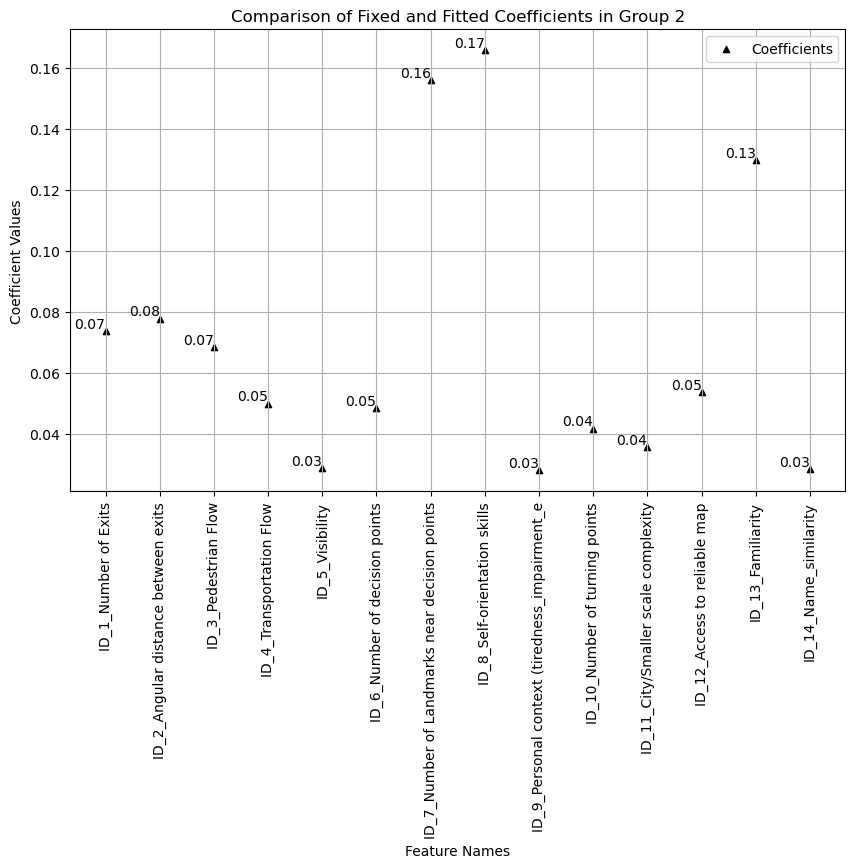

standard deviation of (fix and fit method vs. ahp): 0.05


In [7]:
import numpy as np
from scipy.optimize import minimize
fixed_coefficients = {'ID_6_Number of decision points': ahp_group_dict['ID_6_Number of decision points'], \
                      'ID_8_Self-orientation skills': ahp_group_dict['ID_8_Self-orientation skills'], \
                      'ID_10_Number of turning points': ahp_group_dict['ID_10_Number of turning points'], \
                      'ID_11_City/Smaller scale complexity': ahp_group_dict['ID_11_City/Smaller scale complexity']} # features that remain constant across group 1 or 2. 

# Seperate the features (X) of group 2 into two subgroups:
# 1. X_to_fit: The subgroup of features that we wish to explore their coefficients. 
# 2. X_fixed: The subgroup of features that we keep their coefficients identical to ahp weights, due to the fact that we assigned their score (not from the survey)
X_to_fit = X.drop(columns=fixed_coefficients.keys()).copy() # unconstant features
X_fixed = X[fixed_coefficients.keys()].copy() # constant features

def loss_function(coeffs, X_to_fit, y, X_fixed, fixed_coeffs, lambda_):
    total_coeffs = {**dict(zip(X_to_fit.columns, coeffs)), **fixed_coeffs}
    y_pred = X_to_fit.assign(**X_fixed).dot(pd.Series(total_coeffs))
    mse = np.mean((y - y_pred) ** 2)
    l2_penalty = lambda_ * np.sum(np.square(list(coeffs)))
    return mse + l2_penalty
# regularisation factor
lambda_ = 0.1


result = minimize(loss_function, initial_coeffs, args=(X_to_fit, y, X_fixed, fixed_coefficients, lambda_), constraints=cons, bounds=bounds)

# initialize the coeffs.
initial_coeffs = np.ones(len(X_to_fit.columns))

# constraint 1: all coeffs are added up to 0.71. 
cons = ({'type': 'eq', 'fun': lambda coeffs:  np.sum(coeffs) - 0.71})
# constraint 2: bound of each coeff starts from zero (i.e., no negative coeff.)
bounds = [(0, None) for _ in range(X.shape[1]-4)]

fitted_coeffs = dict(zip(X_to_fit.columns, result.x))

all_coeffs = {**fitted_coeffs, **fixed_coefficients}

# plot fix_and_fit method
ordered_keys = ahp_group_dict.keys()
ordered_values = [all_coeffs[key] for key in ordered_keys if key in all_coeffs]

plt.figure(figsize=(10, 6))
plt.scatter(ordered_keys, ordered_values, label='Coefficients', marker='^', s=20, color='black')

for key, value in all_coeffs.items():
    plt.text(key, value, f"{value:.2f}", ha='right', va='bottom')
plt.xlabel('Feature Names')
plt.ylabel('Coefficient Values')
plt.xticks(rotation=90)
plt.title('Comparison of Fixed and Fitted Coefficients in Group 2')
plt.legend()
plt.grid(True)
plt.show()

# print the variance of derived coeffs and ahp weights
differences = []
for key in all_coeffs:
    if key in ahp_group_dict:
        diff = all_coeffs[key] - ahp_group_dict[key]
        differences.append(diff)
std = np.std(differences)
print(f"standard deviation of (fix and fit method vs. ahp): {std:.2f}")

# 5. Result plotting

 - Blue line stands for the ahp weights from group 1. 
 - Coeffs identified from OLS, Ridge and Fix & Fit of group 2 are represented by red, green and black markers. 

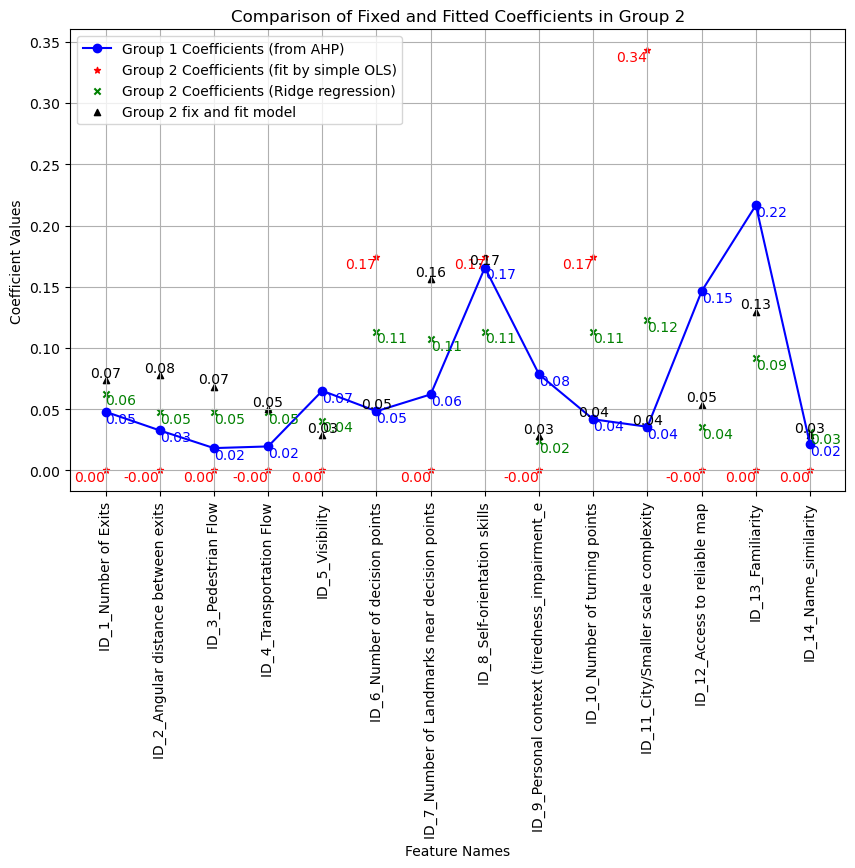

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))    
plt.plot(list(ahp_group_dict.keys()), list(ahp_group_dict.values()), label='Group 1 Coefficients (from AHP)', marker='o', color='b')

for key, value in ahp_group_dict.items():
    plt.text(key, value, f"{value:.2f}", ha='left', va='top', color='b')

plt.scatter(OLS_coeffs.index, OLS_coeffs.values, label='Group 2 Coefficients (fit by simple OLS)', marker='*', s=20, color='r')
for idx, value in enumerate(OLS_coeffs.values):
    plt.text(OLS_coeffs.index[idx], value, f"{value:.2f}", ha='right', va='top', color='r')

plt.scatter(fitted_coeffs_dict.keys(), fitted_coeffs_dict.values(), label='Group 2 Coefficients (Ridge regression)', marker='x', s=20, color='g')
for key, coeff_value in fitted_coeffs_dict.items():
    plt.text(key, coeff_value, f"{coeff_value:.2f}", ha='left', va='top', color='g')

plt.scatter(ordered_keys, ordered_values, label='Group 2 fix and fit model', marker='^', s=20, color='black')
for key, value in all_coeffs.items():
    plt.text(key, value, f"{value:.2f}", ha='center', va='bottom')
    
plt.xlabel('Feature Names')
plt.ylabel('Coefficient Values')
plt.xticks(rotation=90)
plt.title('Comparison of Fixed and Fitted Coefficients in Group 2')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
print(f"Group 1 ahp:")
sum = 0
for key, value in ahp_group_dict.items():
    print(f"{key:50} {value:5.2f}")
    sum += value
print(f"sum is: {sum}")
print("\n")

print(f"Group 2 coeffs of simple OLS:")
sum = 0
for key, value in OLS_coeffs.items():
    print(f"{key:50} {value:5.2f}")
    sum += value
print(f"sum is: {sum}")
print("\n")

print(f"Group 2 coeffs of constrainted fitting (sum = 1):")
sum = 0
for key, value in fitted_coeffs_dict.items():
#     print(f"{key:50}: {value:>5 .2f}")
    print(f"{key:50} {value:5.2f}")
    sum += value
print(f"sum is: {sum}")
print("\n")
    
print(f"Group 2 coeffs of fix and fit (sum = 1):")
sum = 0
for key, value in zip(ordered_keys, ordered_values):
    print(f"{key:50} {value:5.2f}")
    sum += value
print(f"sum is: {sum}")
print("\n")


Group 1 ahp:
ID_1_Number of Exits                                0.05
ID_2_Angular distance between exits                 0.03
ID_3_Pedestrian Flow                                0.02
ID_4_Transportation Flow                            0.02
ID_5_Visibility                                     0.07
ID_6_Number of decision points                      0.05
ID_7_Number of Landmarks near decision points       0.06
ID_8_Self-orientation skills                        0.17
ID_9_Personal context (tiredness_impairment_e       0.08
ID_10_Number of turning points                      0.04
ID_11_City/Smaller scale complexity                 0.04
ID_12_Access to reliable map                        0.15
ID_13_Familiarity                                   0.22
ID_14_Name_similarity                               0.02
sum is: 1.000001


Group 2 coeffs of simple OLS:
ID_1_Number of Exits                                0.00
ID_2_Angular distance between exits                -0.00
ID_3_Pedestrian Flow      

# 6. Shapiro Wilk Test and Q-Q plot for coeffs

 - As our target is to measure the significance of difference between ahp weights (from group 1) and the coeffs that we identified through three proposed methods, testing the normality of these coeffs' distributions is necessary. 
 - In this section, we investigate the normality by two methods: 1. Shapiro-Wilk Test and Q-Q plot. 
 - The result of Shapiro-Wilk test indicates that all of the four distributions (1 from group 1 and 3 from group 2) do not follow a normal distribution as no p-value is above the thresold criteria (0.05)
 - The visualisation via Q-Q plot also confirms the conclusion as the dots are not linearily aligned.
 - As a result, applying t-test on the next step comparison is not of interest, as our coeff data is not normaly distributed and we already know that there is no difference in their average ($H_0$ of t-test), as each group is added up to 1.  

Shapiro-Wilk Test Statistic on Group 1: 0.80, 
P-value: 0.005
The distribution of group 1 may NOT follow normal distribution.

Shapiro-Wilk Test Statistic on Group 2 (Ridge): 0.63, 
P-value: 0.000
The distribution of group 2 may NOT follow normal distribution.

Shapiro-Wilk Test Statistic on Group 2 (Ridge): 0.86, 
P-value: 0.027
The distribution of group 2 may NOT follow normal distribution.

Shapiro-Wilk Test Statistic on Group 2 (Fix and Fit): 0.82 
P-value: 0.008
The distribution of group 2 may NOT follow normal distribution.



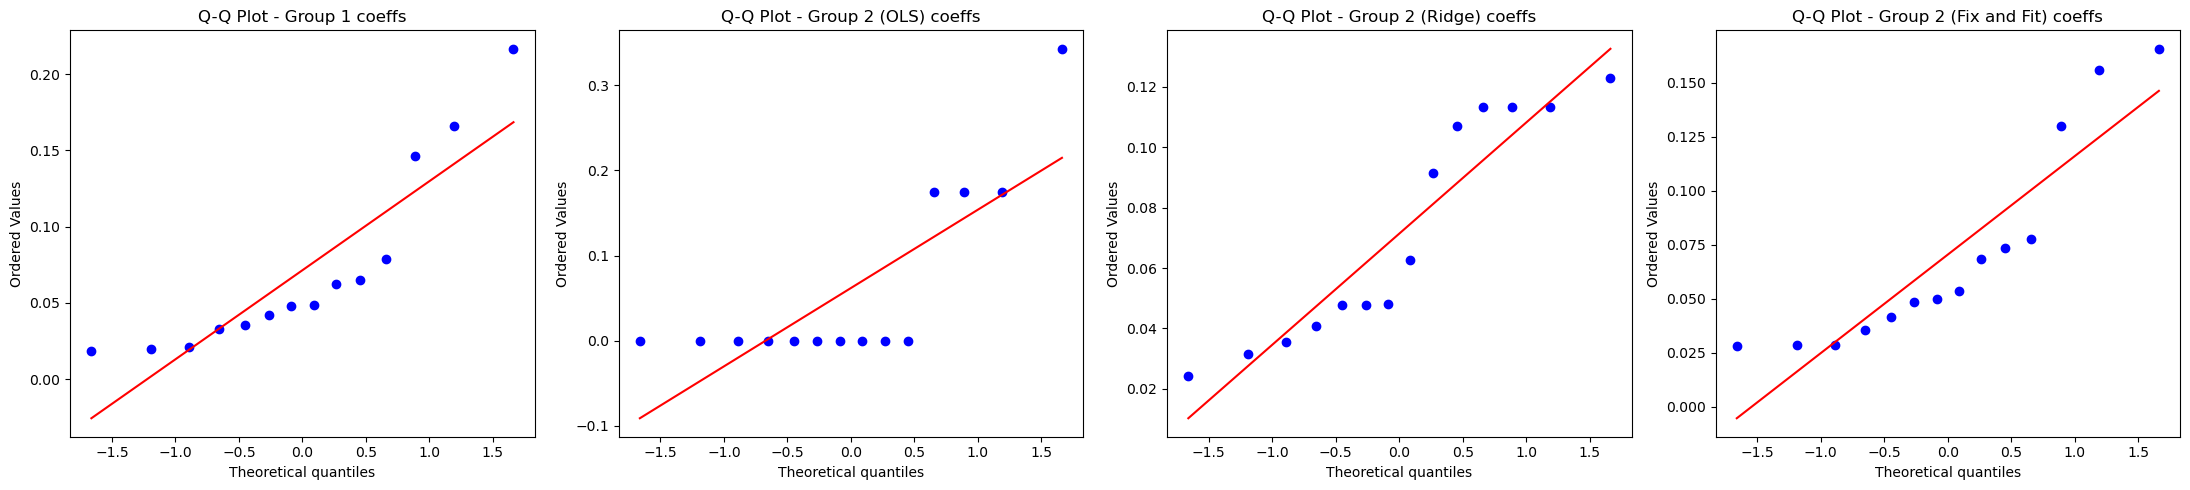

In [10]:
import pandas as pd
import numpy as np
from scipy import stats

group_1_coeff_AHP = np.array(list(ahp_group_dict.values()))
group_2_coeff_OLS = np.array(list(OLS_coeffs.values))
group_2_coeff_ridge = np.array(list(fitted_coeffs_dict.values()))
group_2_coeff_fix_and_fit = np.array(list(ordered_values))

# Shapiro-Wilk test on Group 1 AHP coeffs
shapiro_test_group_1 = stats.shapiro(group_1_coeff_AHP)
print(f"Shapiro-Wilk Test Statistic on Group 1: {shapiro_test_group_1.statistic:.2f}, \nP-value: {shapiro_test_group_1.pvalue:.3f}")
# Normality test result output based on p-value.
if shapiro_test_group_1.pvalue > 0.05:
    print(f"The distribution of group 1 may follow normal distribution.\n")
else:
    print("The distribution of group 1 may NOT follow normal distribution.\n")

# Shapiro-Wilk test on Group 2 OLS coeffs 
shapiro_test_group_2_OLS = stats.shapiro(group_2_coeff_OLS)
print(f"Shapiro-Wilk Test Statistic on Group 2 (Ridge): {shapiro_test_group_2_OLS.statistic:.2f}, \nP-value: {shapiro_test_group_2_OLS.pvalue:.3f}")
# Normality test result output based on p-value.
if shapiro_test_group_2_OLS.pvalue > 0.05:
    print(f"The distribution of group 2 may follow normal distribution.\n")
else:
    print("The distribution of group 2 may NOT follow normal distribution.\n")
    
# Shapiro-Wilk test on Group 2 Ridge-Regression coeffs 
shapiro_test_group_2_ridge = stats.shapiro(group_2_coeff_ridge)
print(f"Shapiro-Wilk Test Statistic on Group 2 (Ridge): {shapiro_test_group_2_ridge.statistic:.2f}, \nP-value: {shapiro_test_group_2_ridge.pvalue:.3f}")
# Normality test result output based on p-value.
if shapiro_test_group_2_ridge.pvalue > 0.05:
    print(f"The distribution of group 2 may follow normal distribution.\n")
else:
    print("The distribution of group 2 may NOT follow normal distribution.\n")
    
    
# Shapiro-Wilk test on Group 2 fix-fit method coeffs 
shapiro_test_group_2_fixNfit = stats.shapiro(group_2_coeff_fix_and_fit)
print(f"Shapiro-Wilk Test Statistic on Group 2 (Fix and Fit): {shapiro_test_group_2_fixNfit.statistic:.2f} \nP-value: {shapiro_test_group_2_fixNfit.pvalue:.3f}")
# Normality test result output based on p-value.
if shapiro_test_group_2_fixNfit.pvalue > 0.05:
    print(f"The distribution of group 2 may follow normal distribution.\n")
else:
    print("The distribution of group 2 may NOT follow normal distribution.\n")
    

import scipy.stats as stats
fig, axs = plt.subplots(1, 4, figsize=(22, 5))

stats.probplot(group_1_coeff_AHP, dist="norm", plot=axs[0])
axs[0].set_title("Q-Q Plot - Group 1 coeffs")

stats.probplot(group_2_coeff_OLS, dist="norm", plot=axs[1])
axs[1].set_title("Q-Q Plot - Group 2 (OLS) coeffs")

stats.probplot(group_2_coeff_ridge, dist="norm", plot=axs[2])
axs[2].set_title("Q-Q Plot - Group 2 (Ridge) coeffs")

stats.probplot(group_2_coeff_fix_and_fit, dist="norm", plot=axs[3])
axs[3].set_title("Q-Q Plot - Group 2 (Fix and Fit) coeffs")

plt.tight_layout()
plt.show()


# 7. Wilcoxon signed-rank test on coeffs of group 1 and 2
 - Though we already expected that t-test will not be a efficient way for the comparison of ahp_weights from group_1 and the coeffs we derived from group_2, I still added the results of t-test below. Not surprisingly, all the p-values are quite close to 1. Namely the $H_0$ of t-test cannot be rejected. 
 - The result of W-test shows that all of the three sets of coeffs of group 2 have the same distribution as ahp weights (p-value>>0.05), which shouldn't be the case. At least, intuitively, the coeffs from simple OLS is very unlikely to be identically distributed as ahp weights, due to its all-zeros on 10 factors. 
 - Based on this paper ***Use of statistical programs for nonparametric tests of small samples often leads to incorrect P values: examples from Animal Behaviour***, I think our data size is to small to apply W-test. The minimum sample size recommanded for W-test in this paper is 16, however, we have 14 factors to compare. 

In [11]:
from scipy.stats import ttest_rel

for coeff, name in zip([group_2_coeff_OLS, group_2_coeff_ridge, group_2_coeff_fix_and_fit], ['AHP and OLS', 'AHP and Ridge', 'AHP and Fix/Fit']):
    t_statistic, p_value = ttest_rel(group_1_coeff_AHP, coeff)
    print(f"t-test of {name}, T-statistic: {t_statistic:.3f}, P-value: {p_value:.3f}")

print("\n")

from scipy.stats import wilcoxon
for coeff, name in zip([group_2_coeff_OLS, group_2_coeff_ridge, group_2_coeff_fix_and_fit], ['AHP and OLS', 'AHP and Ridge', 'AHP and Fix/Fit']):
    w_statistic, p_value = wilcoxon(group_1_coeff_AHP, coeff)
    print(f"W-test of {name}, W-statistic: {t_statistic:.3f}, P-value: {p_value:.3f}")


t-test of AHP and OLS, T-statistic: 0.281, P-value: 0.783
t-test of AHP and Ridge, T-statistic: 0.000, P-value: 1.000
t-test of AHP and Fix/Fit, T-statistic: 0.070, P-value: 0.945


W-test of AHP and OLS, W-statistic: 0.070, P-value: 0.326
W-test of AHP and Ridge, W-statistic: 0.070, P-value: 0.808
W-test of AHP and Fix/Fit, W-statistic: 0.070, P-value: 0.959


C:\Users\2715439W\AppData\Local\miniconda3\envs\tf2\lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


# Annex: stats summary

In [30]:
df = pd.DataFrame({
    'Group 1 AHP': group_1_coeff_AHP,
    'Group 2 OLS': group_2_coeff_OLS,
    'Group 2 Ridge': group_2_coeff_ridge,
    'Group 2 Fix and Fit': group_2_coeff_fix_and_fit
})
pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.expand_frame_repr', False)
percentiles = [0.25, 0.5, 0.75]  

stats_summary = df.describe(percentiles=percentiles).T

print(stats_summary)

                     count  mean   std    min    25%   50%   75%   max
Group 1 AHP         14.000 0.071 0.061  0.018  0.033 0.048 0.075 0.217
Group 2 OLS         14.000 0.062 0.109 -0.000 -0.000 0.000 0.131 0.343
Group 2 Ridge       14.000 0.071 0.037  0.024  0.042 0.055 0.112 0.123
Group 2 Fix and Fit 14.000 0.070 0.047  0.028  0.037 0.052 0.077 0.166
